<h1 style="color:#159364; font-family:verdana;"> <center>American companies Bankruptcy prediction</center> </h1>

<div class="alert alert-block alert-info" style="background-color:#b7f7c8; font-size:15px; font-family:verdana;"> <div>
    A novel dataset for bankruptcy prediction related to American public companies listed on the New York Stock Exchange and NASDAQ is provided. The dataset comprises accounting data from 8,262 distinct companies recorded during the period spanning from 1999 to 2018.
    
According to the Security Exchange Commission (SEC), a company in the American market is deemed bankrupt under two circumstances. Firstly, if the firm's management files for Chapter 11 of the Bankruptcy Code, indicating an intention to "reorganize" its business. In this case, the company's management continues to oversee day-to-day operations, but significant business decisions necessitate approval from a bankruptcy court. Secondly, if the firm's management files for Chapter 7 of the Bankruptcy Code, indicating a complete cessation of operations and the company going out of business entirely.

In this dataset, the fiscal year prior to the filing of bankruptcy under either Chapter 11 or Chapter 7 is labeled as "Bankruptcy" (1) for the subsequent year. Conversely, if the company does not experience these bankruptcy events, it is considered to be operating normally (0). The dataset is complete, without any missing values, synthetic entries, or imputed added values.

The resulting dataset comprises a total of 78,682 observations of firm-year combinations. To facilitate model training and evaluation, the dataset is divided into three subsets based on time periods. The training set consists of data from 1999 to 2011, the validation set comprises data from 2012 to 2014, and the test set encompasses the years 2015 to 2018. The test set serves as a means to assess the predictive capability of models in real-world scenarios involving unseen cases. 


In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Data Overview

In [3]:
df= pd.read_csv('/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv')
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


# Summary Table

In [4]:
# summary table function
def summary(df):
    # Print the shape of the DataFrame
    print(f'data shape: {df.shape}')  
    # Create a summary DataFrame
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    # Calculate the number of missing values
    summ['#missing'] = df.isnull().sum().values 
    # Calculate the percentage of missing values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    # Calculate the number of unique values
    summ['#unique'] = df.nunique().values
    # Create a descriptive DataFrame
    desc = pd.DataFrame(df.describe(include='all').transpose())
    # Add the minimum, maximum, and first three values to the summary DataFrame
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    # Return the summary DataFrame
    return summ

In [5]:
summary(df)

data shape: (78682, 21)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
company_name,object,0,0.0,8971,NaN,NaN,C_1,C_1,C_1
status_label,object,0,0.0,2,NaN,NaN,alive,alive,alive
year,int64,0,0.0,20,1999.0,2018.0,1999,2000,2001
X1,float64,0,0.0,65895,-7.76,169662.0,511.267,485.856,436.656
X2,float64,0,0.0,65690,-366.645,374623.0,833.107,713.811,526.477
X3,float64,0,0.0,36010,0.0,28430.0,18.373,18.577,22.496
X4,float64,0,0.0,59060,-21913.0,81730.0,89.031,64.367,27.207
X5,float64,0,0.0,38898,0.0,62567.0,336.018,320.59,286.588
X6,float64,0,0.0,55550,-98696.0,104821.0,35.163,18.531,-58.939
X7,float64,0,0.0,49577,-0.006,65812.0,128.348,115.187,77.528


# Pre-Processing

In [6]:
df['status_label'] = df['status_label'].map({'alive': 1, 'failed': 0})
df = df.drop(['company_name', 'year'], axis=1)

# Model and Eval

Accuracy: 0.932198004702294
Confusion Matrix:
[[    7  1061]
 [    6 14663]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.01      0.01      1068
           1       0.93      1.00      0.96     14669

    accuracy                           0.93     15737
   macro avg       0.74      0.50      0.49     15737
weighted avg       0.91      0.93      0.90     15737



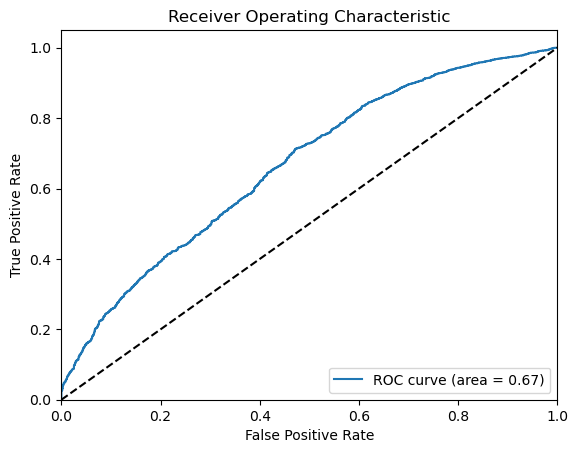

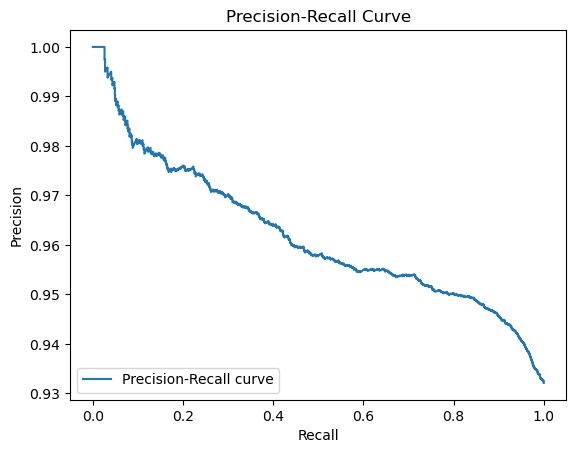

Cross-Validation Scores: [0.9346127  0.9316261  0.93174886 0.93397306 0.93359176]
Average Cross-Validation Score: 0.9331104951855582


In [7]:
X = df.drop('status_label', axis=1)
y = df['status_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=2000) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

probas = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, probas[:, 1])

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print('Cross-Validation Scores:', cv_scores)
print('Average Cross-Validation Score:', np.mean(cv_scores))

# Feature Importance

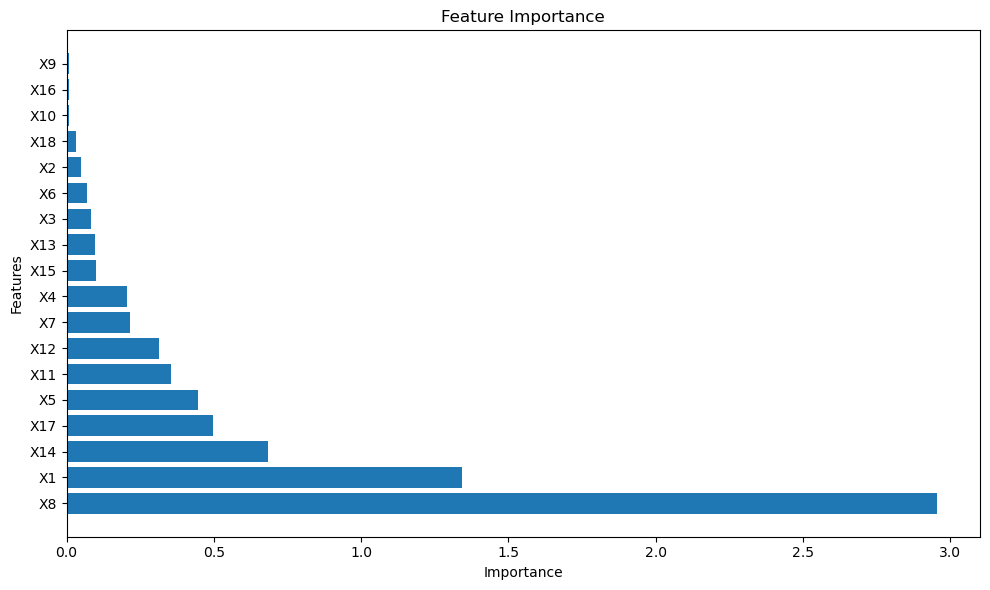

In [8]:
feature_importance = np.abs(model.coef_[0])
feature_names = df.drop('status_label', axis=1).columns
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(feature_importance)), sorted_feature_names)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()